In [1]:
%matplotlib inline

from database.DataBaseModels import *

import pygal
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
author_undigraph_cycle = nx.Graph()
article_digraph = nx.MultiDiGraph()
article_undigraph_cycle = nx.Graph()

In [3]:
article_labels_dict = {}
article_list = []
article_cycle_list = []
article_for_removing_list = []

for citation in db.Citation.select():
    article_digraph.add_edge(citation.cited_by, citation.article_id)
    
article_digraph.remove_edges_from([edge for edge in article_digraph.selfloop_edges()])

for node in article_digraph.nodes:
    if node.venue_id == None or node.venue_id.name == 'None':
        article_for_removing_list.append(node)

article_digraph.remove_nodes_from(article_for_removing_list)

for article_node in article_digraph.nodes:
    if article_node.venue_id == None:
        pass
    for successor in article_digraph.successors(article_node):
        if article_node in article_digraph.successors(successor):
            article_cycle_list.append([successor, article_node])

for edge in article_cycle_list:
    article_cycle_list.remove([edge[1], edge[0]])
    
for edge in article_cycle_list:
    article_labels_dict[edge[0]] = '{0}: {1}'.format(edge[0].venue_id.name, edge[0].article_id)
    article_labels_dict[edge[1]] = '{0}: {1}'.format(edge[1].venue_id.name, edge[1].article_id)
    article_undigraph_cycle.add_edge(edge[0], edge[1])

print('Number of nodes in undirected graph just with cyclic citations of article: {0}'.format(len(article_undigraph_cycle.nodes)))
print('Number of edges in undirected graph just with cyclic citations of article: {0}'.format(len(article_undigraph_cycle.edges)))

Number of nodes in undirected graph just with cyclic citations of article: 98
Number of edges in undirected graph just with cyclic citations of article: 58


In [4]:
article_subundigraph_list = list(nx.connected_component_subgraphs(article_undigraph_cycle))
print('Number of distinct graphs in undirected graph just with cyclic citations of article: {0}'.format(len(article_subundigraph_list)))

Number of distinct graphs in undirected graph just with cyclic citations of article: 40


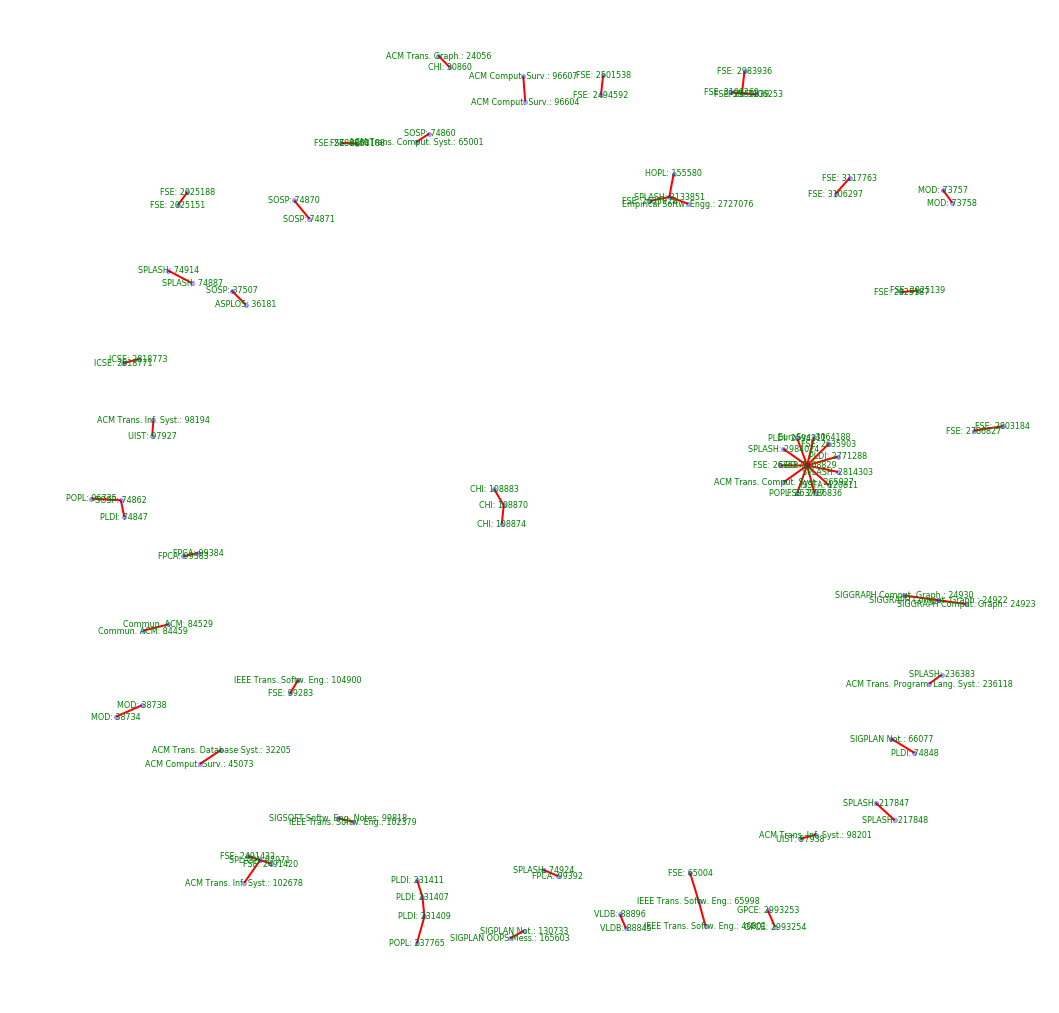

In [9]:
NODE_SIZE = 16
WIDTH = 2
NODE_COLOR = 'blue'
EDGE_COLOR = 'red'

graph_pos = nx.spring_layout(article_undigraph_cycle)

plt.figure(figsize=(18,18))

nx.draw_networkx_nodes(article_undigraph_cycle,
                      graph_pos,
                      node_size=NODE_SIZE,
                      node_color=NODE_COLOR,
                      alpha=0.3)
nx.draw_networkx_edges(article_undigraph_cycle,
                      graph_pos,
                      edge_color=EDGE_COLOR,
                      width=WIDTH)
nx.draw_networkx_labels(article_undigraph_cycle,
                       graph_pos,
                       labels=article_labels_dict,
                       font_size=8,
                       font_family='sans-serif',
                       font_color='green')

plt.axis('off')
plt.savefig("visualization/cycles_in_article_citations.pdf")
plt.show()

In [6]:
author_list = []
author_lables_dict = {}

for article_node in article_undigraph_cycle.nodes:
    for author_article in article_node.article__author_article:
        if author_article.author_id not in author_list:
            author_list.append(author_article.author_id)

for article_node in article_undigraph_cycle.nodes:
    author_list_1 = [author_article.author_id for author_article in article_node.article__author_article]
    author_list_2 = []
    for neighbour in article_undigraph_cycle.neighbors(article_node):
        for author_article_2 in neighbour.article__author_article:
            author_list_2.append(author_article_2.author_id)
    for author_1 in author_list_1:
        for author_2 in author_list_2:
            author_lables_dict[author_1] = author_1.name
            author_lables_dict[author_2] = author_2.name
            author_undigraph_cycle.add_edge(author_1, author_2)

print('Number of nodes in undirected graph just with cyclic citations of authors: {0}'.format(len(author_undigraph_cycle.nodes)))
print('Number of edges in undirected graph just with cyclic citations of authors: {0}'.format(len(author_undigraph_cycle.edges)))

Number of nodes in undirected graph just with cyclic citations of authors: 224
Number of edges in undirected graph just with cyclic citations of authors: 502


In [7]:
author_subundigraph_list = list(nx.connected_component_subgraphs(author_undigraph_cycle))
print('Number of distinct graphs in undirected graph just with cyclic citations of article: {0}'.format(len(author_subundigraph_list)))

Number of distinct graphs in undirected graph just with cyclic citations of article: 31


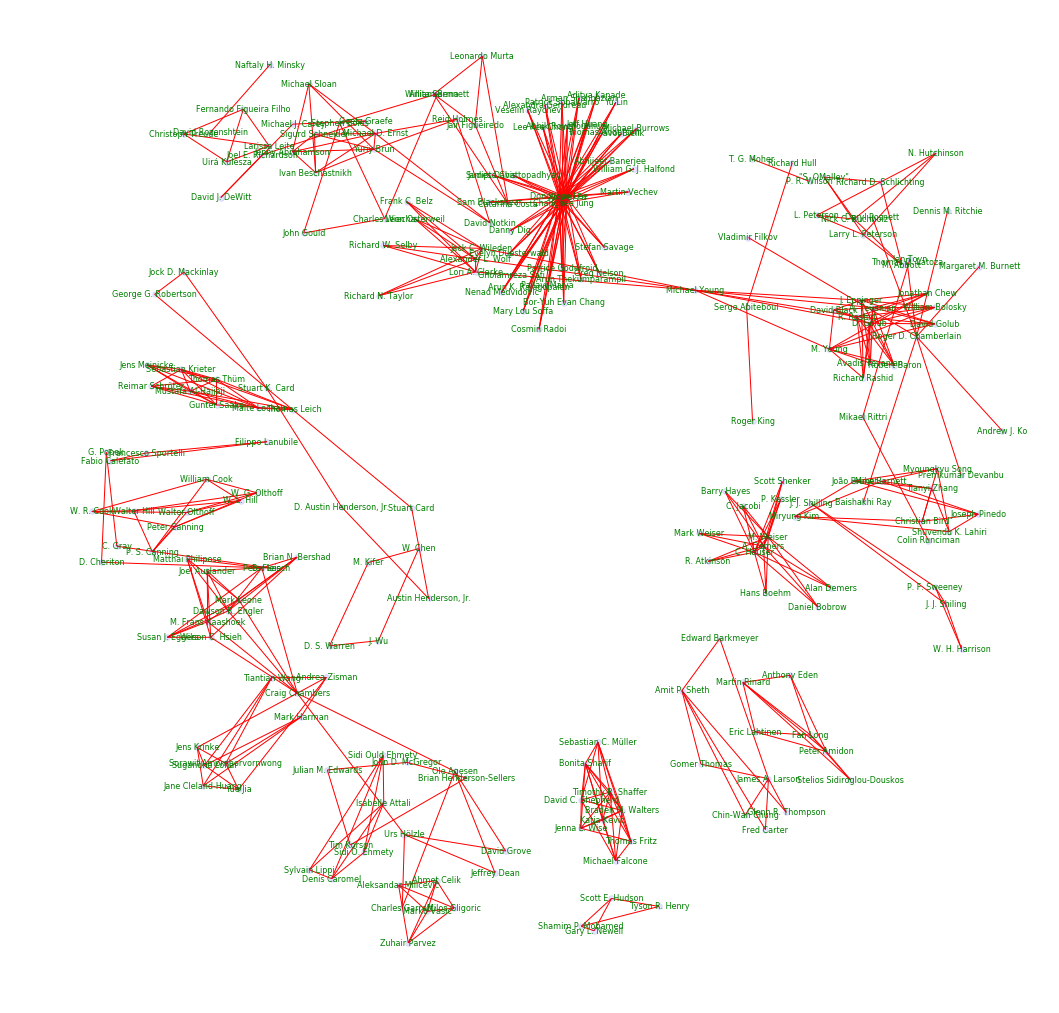

In [10]:
NODE_SIZE = 32
WIDTH = 1
NODE_COLOR = 'blue'
EDGE_COLOR = 'red'

graph_pos = nx.spring_layout(author_undigraph_cycle, k=0.25)

plt.figure(figsize=(18,18))

nx.draw_networkx_nodes(author_undigraph_cycle,
                      graph_pos,
                      node_size=NODE_SIZE,
                      node_color=NODE_COLOR,
                      alpha=0.1)
nx.draw_networkx_edges(author_undigraph_cycle,
                      graph_pos,
                      edge_color=EDGE_COLOR,
                      width=WIDTH)
nx.draw_networkx_labels(author_undigraph_cycle,
                       graph_pos,
                       labels=author_lables_dict,
                       font_size=8,
                       font_family='sans-serif',
                       font_color='green')

plt.axis('off')
plt.savefig("visualization/cycles_in_authors_citations.pdf")
plt.show()